In [2]:
%matplotlib inline

In [3]:
import rasterio
from glob import glob
from matplotlib import pyplot
import numpy as np

In [4]:
rasters_fp = glob('../datos/MDE/*.tif')

In [5]:
rasters_fp

['../datos/MDE/m001ef5.tif',
 '../datos/MDE/m002ef5.tif',
 '../datos/MDE/m014gh1.tif',
 '../datos/MDE/m015gh1.tif',
 '../datos/MDE/m018go1.tif']

In [6]:
mammal_1 = rasterio.open(rasters_fp[0])

In [7]:
mammal_1.__class__

rasterio._io.RasterReader

In [8]:
mammal_1.read_crs()

CRS({u'lon_0': -102, u'datum': u'WGS84', u'y_0': 0, u'no_defs': True, u'proj': u'lcc', u'x_0': 2500000, u'units': u'm', u'lat_2': 29.5, u'lat_1': 17.5, u'lat_0': 12})

In [9]:
mammal_1.shape

(2090, 3293)

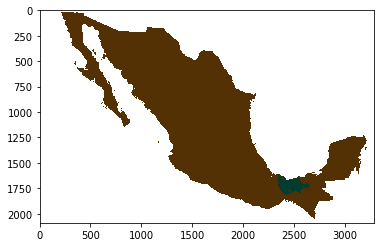

In [10]:
pyplot.imshow(np.ma.masked_equal(mammal_1.read(1), 255), cmap='BrBG')

In [11]:
mammal_2 = rasterio.open(rasters_fp[1])

In [12]:
mammal_2.shape

(2090, 3293)

In [13]:
mammal_2.bounds

BoundingBox(left=860679.3743839164, bottom=282447.16873931885, right=4153679.374383916, top=2372447.168739319)

In [14]:
mammal_1.bounds

BoundingBox(left=860679.3743839164, bottom=282447.16873931885, right=4153679.374383916, top=2372447.168739319)

In [15]:
mammal_1.count

1

In [16]:
mammal_1_arr = np.ma.masked_equal(mammal_1.read(1), mammal_1.nodata)

In [17]:
mammal_2_arr = np.ma.masked_equal(mammal_2.read(1), mammal_2.nodata)

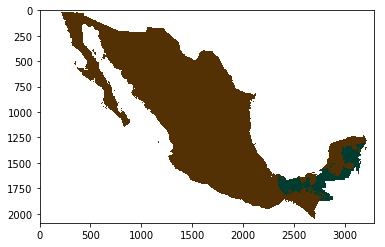

In [18]:
pyplot.imshow((mammal_1_arr+mammal_2_arr > 0), cmap='BrBG')

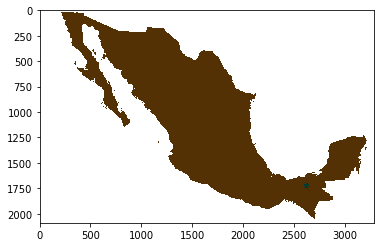

In [19]:
pyplot.imshow(mammal_1_arr*mammal_2_arr, cmap='BrBG')

In [20]:
import geopandas as gpd

In [21]:
estados_fp = '../datos/destdv1gw_c/destdv1cw.shp'

In [22]:
estados_gdf = gpd.GeoDataFrame.from_file(estados_fp)

In [23]:
estados_gdf = estados_gdf[['ENTIDAD', 'geometry']]

In [24]:
estados_gdf.head()

,ENTIDAD,geometry
0,BAJA CALIFORNIA,"POLYGON ((1071602.946584179 2349608.235864431,..."
1,BAJA CALIFORNIA,"POLYGON ((1054554.023911037 2340187.4126439, 1..."
2,BAJA CALIFORNIA,"POLYGON ((1057686.603394306 2337959.410386244,..."
3,BAJA CALIFORNIA,"POLYGON ((1059225.740030776 2335282.153000345,..."
4,SONORA,"POLYGON ((1291139.924194857 2322890.567642324,..."


In [25]:
estados_gdf.crs

{u'datum': u'WGS84',
 u'lat_0': 12,
 u'lat_1': 17.5,
 u'lat_2': 29.5,
 u'lon_0': -102,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'm',
 u'x_0': 2500000,
 u'y_0': 0}

In [26]:
crs = mammal_1.read_crs()

In [27]:
crs.to_dict()

{u'datum': u'WGS84',
 u'lat_0': 12,
 u'lat_1': 17.5,
 u'lat_2': 29.5,
 u'lon_0': -102,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'm',
 u'x_0': 2500000,
 u'y_0': 0}

In [35]:
estado_geom = estados_gdf[estados_gdf.ENTIDAD == 'DURANGO'].unary_union

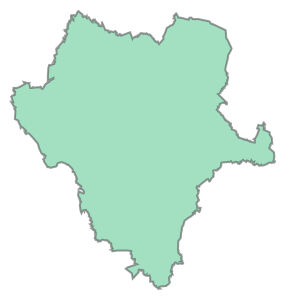

In [36]:
estado_geom

In [37]:
estado_geom.bounds

(1978328.1574918753, 1149428.577085292, 2452336.9705960234, 1648691.357150454)

In [38]:
window_estado = mammal_1.window(*estado_geom.bounds)

In [38]:
?mammal_1.window

In [39]:
window_estado

((723, 1224), (1117, 1592))

In [40]:
out_transform_estado = mammal_1.window_transform(window_estado)

In [41]:
out_transform_estado

Affine(1000.0, 0.0, 1977679.3743839164,
       0.0, -1000.0, 1649447.1687393188)

In [42]:
distribution_cut = mammal_1.read(window=window_estado, masked=True)

In [43]:
distribution_cut.shape

(1, 501, 475)

In [44]:
from rasterio.features import rasterize

In [48]:
estado_mask = rasterize([ estado_geom ], out_shape=distribution_cut.shape[1:], transform=out_transform_estado, fill=0, default_value=1)

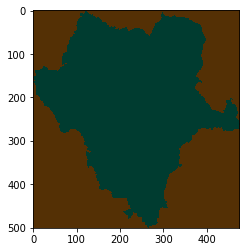

In [49]:
pyplot.imshow(estado_mask, cmap='BrBG')

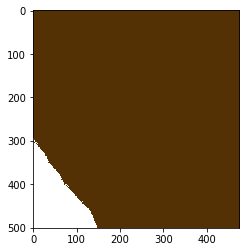

In [50]:
pyplot.imshow(estado_mask*distribution_cut[0,:,:], cmap='BrBG')

In [120]:
out_image = mammal_1.read(window=window, masked=True)

In [121]:
out_shape = out_image.shape[1:]

In [122]:
from rasterio.features import geometry_mask



In [123]:
shape_mask = geometry_mask(estados_features[:5], transform=out_transform, invert=False,
                               out_shape=out_shape, all_touched=False)

In [124]:
out_image.mask = out_image.mask | shape_mask

In [125]:
out_image.fill_value = mammal_1.nodata

In [126]:
for i in range(mammal_1.count):
        out_image[i] = out_image[i].filled(mammal_1.nodata)

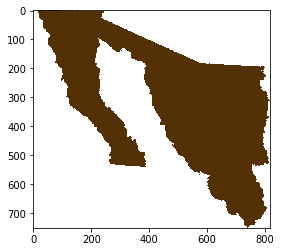

In [127]:
pyplot.imshow(np.ma.masked_equal(out_image[0,:,:], mammal_1.nodata), cmap='BrBG')

In [57]:
out_image, out_transform = rasterio.tools.mask.mask(mammal_1, estados_features,
                                                        crop=True)

TypeError: argument of type 'Polygon' is not iterable